This script fits a variational autoencoder on the time-states of the heat equation simulator. The idea behind this is that solving in the original space might be a difficult task. Inspired from the modern technique of (Conditional) Flow Matching, it may be useful to transform the simulations into a latent space (multivariate gaussian) through a variational autoencoder (VAE). In this well-behaved space, we attempt to fit a nice curve. If such curve can be fit correctly, the heat equation can be solved in the latent space and then be back transformed. 

Let $\Phi^e$ be the encoder into the latent space and $\Phi^d$ be the coder, such that $(\Phi^e\circ\Phi^d)(x)\approx x$. The time series of the heat equation simulator $(H_0)$ is transformed to $\Phi^e(H_0)$, a flow is applied to transform the embedding to the embedding of $H_T$, $\tilde{\Phi^e(H_T)\approx}f(\Phi^e(H_0))$ and we can then back-transform to the original space. So finally
$$H_T \approx \Phi^d(f(\Phi^e(H_0)))$$

This script fits a model for the embeddings $\Phi$.

In [4]:
import os
import csv
import time
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F

from torchsummary import summary

from utils import print_model_information, make_simulations, generate_gaussian_peaks, solve_heat_equation_2d, solve_wave_equation_2d
from VAE_Classes import VAE_Heat, NetworkTrainer

from simulation_class import SimulationModel

Structure of the script:

In [66]:
# Generate training data
equation_type = "heat"
equation_parameter = 3
dimension = 100

inputs_train, output_train = make_simulations(number=10, k=1, nt=10, equation=equation_type, equation_parameter=equation_parameter, as_tensor=True, nx=dimension, ny=dimension)
inputs_train = inputs_train.unsqueeze(1)

torch.save(inputs_train, f'model_parameters/vae/{equation_type}_par{equation_parameter}_dim{dimension}.pth')

inputs_train.shape

torch.Size([90, 1, 100, 100])

In [67]:
# # Generate training data
# equation_type = "heat"
# equation_parameter = 3
# dimension = 100

# inputs_train = torch.load(f'model_parameters/vae/{equation_type}_par{equation_parameter}_dim{dimension}.pth')
# inputs_train = inputs_train.unsqueeze(1)

# output_train = 1
# inputs_train.shape

In [ ]:
# Checking dimensions and summary of VAE
device = "cpu"
vae_kwargs = {"latent_dim": 128, "first_channel": 8, "max_channels": 4, "input_size": (97, 97)}
vae = VAE10_Upsample(**vae_kwargs).to(device) 

with torch.no_grad():
    print(summary(vae, (1, *vae.input_size)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 49, 49]              80
         LeakyReLU-2            [-1, 8, 49, 49]               0
            Conv2d-3           [-1, 16, 25, 25]           1,168
         LeakyReLU-4           [-1, 16, 25, 25]               0
            Conv2d-5           [-1, 32, 13, 13]           4,640
         LeakyReLU-6           [-1, 32, 13, 13]               0
            Conv2d-7              [-1, 4, 7, 7]           1,156
         LeakyReLU-8              [-1, 4, 7, 7]               0
            Linear-9                  [-1, 128]          25,216
           Linear-10                  [-1, 128]          25,216
           Linear-11                  [-1, 196]          25,284
         Upsample-12            [-1, 4, 13, 13]               0
           Conv2d-13           [-1, 32, 13, 13]           1,184
        LeakyReLU-14           [-1, 32,

In [79]:
dimension = 97

inputs_train, output_train = make_simulations(number=250, k=1, nt=250, equation=equation_type, equation_parameter=equation_parameter, as_tensor=True, nx=dimension, ny=dimension)

torch.save(inputs_train, f'data/vae/inputs_simulation_number250_timesteps250_k1.pth')
torch.save(output_train, f'data/vae/outputs_simulation_number250_timesteps250_k1.pth')

inputs_train_min = inputs_train.min()
inputs_train_max = inputs_train.max()
inputs_train = (inputs_train - inputs_train_min) / (inputs_train_max - inputs_train_min)

inputs_train, output_train = inputs_train.unsqueeze(1), 0

print(inputs_train.shape)

torch.Size([62250, 1, 97, 97])


Model parameters loaded from model_parameters/vae/vae_upsample_ld128_fc2_maxchannel8_parameters.pth
Epoch [10/1000] | Loss: BCE+β*KLD = 343.3 + β*12.0 = 345.16 | Time 8.10 min at 48.5 sec/e
Epoch [20/1000] | Loss: BCE+β*KLD = 297.0 + β*34.8 = 304.44 | Time 15.70 min at 47.0 sec/e
Epoch [30/1000] | Loss: BCE+β*KLD = 293.2 + β*27.2 = 300.96 | Time 23.10 min at 46.3 sec/e
Epoch [40/1000] | Loss: BCE+β*KLD = 292.9 + β*23.9 = 301.44 | Time 30.10 min at 45.2 sec/e
Epoch [50/1000] | Loss: BCE+β*KLD = 293.1 + β*21.5 = 302.41 | Time 37.80 min at 45.4 sec/e
Epoch [60/1000] | Loss: BCE+β*KLD = 293.5 + β*19.8 = 303.45 | Time 45.60 min at 45.6 sec/e
Epoch [70/1000] | Loss: BCE+β*KLD = 293.8 + β*18.6 = 304.42 | Time 53.50 min at 45.9 sec/e
Epoch [80/1000] | Loss: BCE+β*KLD = 294.2 + β*17.5 = 305.26 | Time 60.40 min at 45.3 sec/e
Epoch [90/1000] | Loss: BCE+β*KLD = 294.5 + β*16.7 = 306.02 | Time 67.00 min at 44.7 sec/e
Epoch [100/1000] | Loss: BCE+β*KLD = 294.8 + β*16.1 = 306.66 | Time 73.60 min at 4

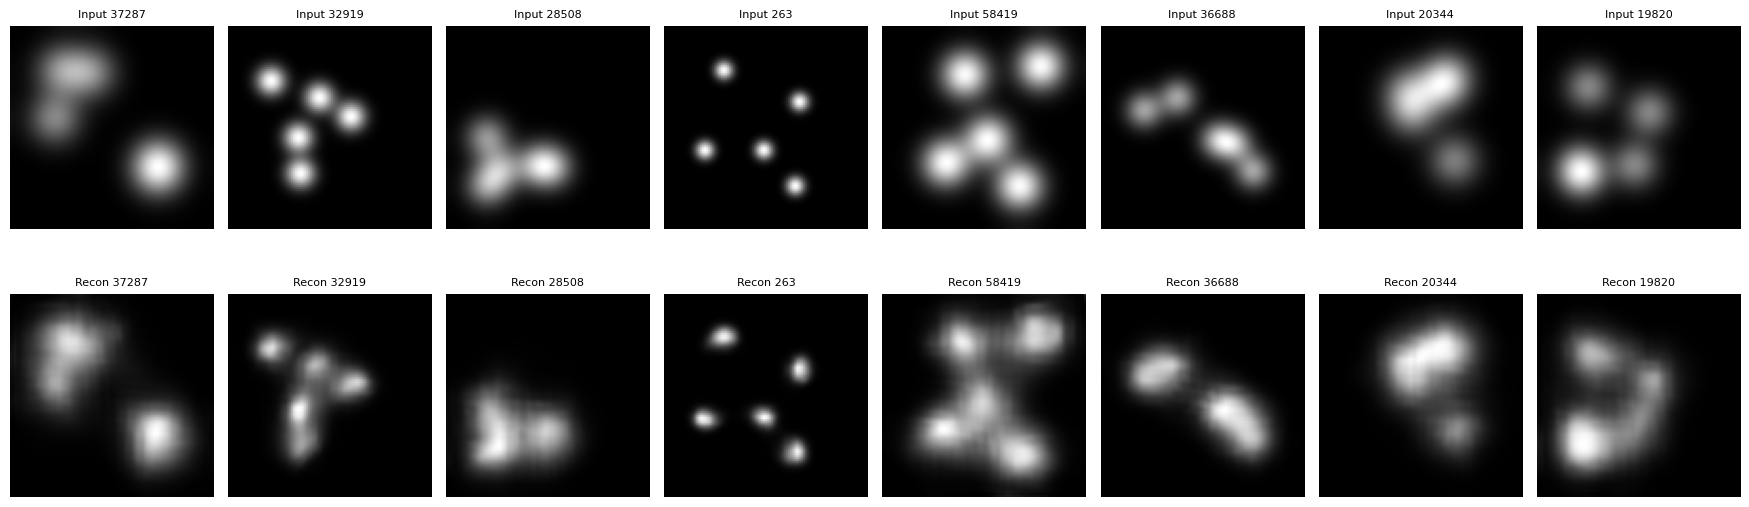

In [ ]:
vae_kwargs = {"latent_dim": 128, "first_channel": 2, "max_channels": 8, "input_size": (97, 97)}

vae_trainer = NetworkTrainer(VAE_Heat, model_kwargs=vae_kwargs, device="cpu", beta_start=10)

vae_trainer.plot_images_and_reconstructions(inputs_train, num_subsamples=8)

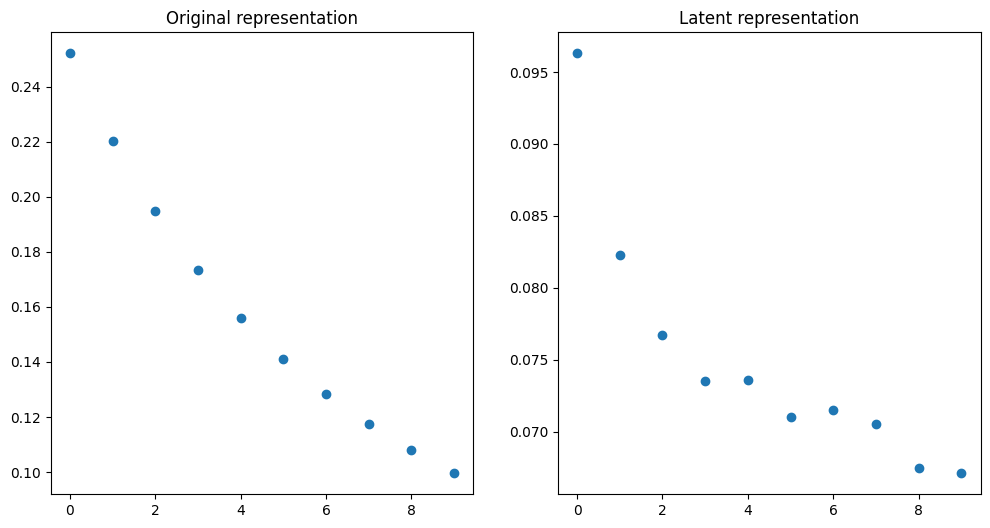

In [81]:
vae_trainer.plot_distances_original_and_latent_space(inputs_train, save_figure=False)

Below, we try a U-Net

In [2]:
pass